     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


<ipython-input-2-c0badc9b5709>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['tweet'].fillna('', inplace=True)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[==================================================] 100.0% 199.5/199.5MB downloaded


<ipython-input-2-c0badc9b5709>:53: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embedding_matrix[i] = gt_vec.word_vec(word)


Epoch 1/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.7326 - loss: 0.5255 - val_accuracy: 0.8379 - val_loss: 0.3895
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.8169 - loss: 0.4102 - val_accuracy: 0.8370 - val_loss: 0.3783
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.7533 - loss: 0.4934 - val_accuracy: 0.7608 - val_loss: 0.5057
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8009 - loss: 0.4378 - val_accuracy: 0.7714 - val_loss: 0.4962
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8215 - loss: 0.4115 - val_accuracy: 0.8255 - val_loss: 0.3880
Test Accuracy: 0.8255


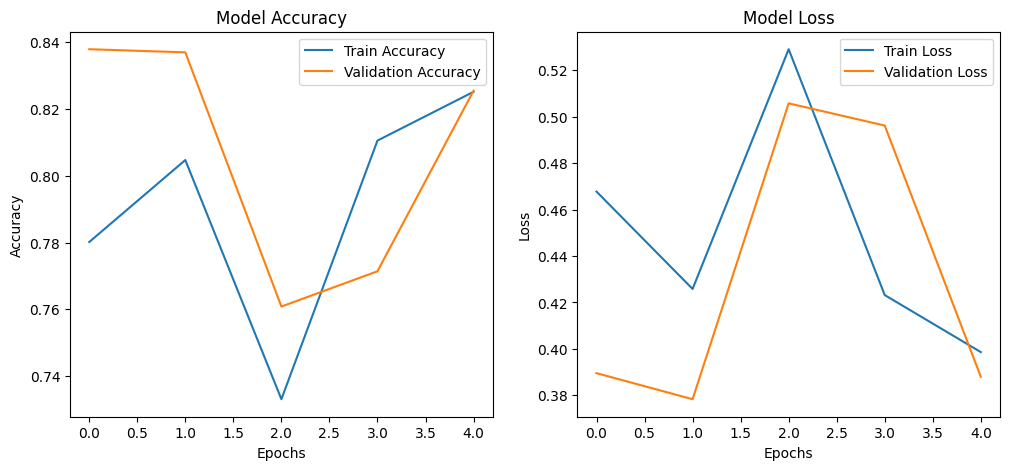

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1901
           1       0.74      0.89      0.81      1314

    accuracy                           0.83      3215
   macro avg       0.82      0.84      0.82      3215
weighted avg       0.84      0.83      0.83      3215



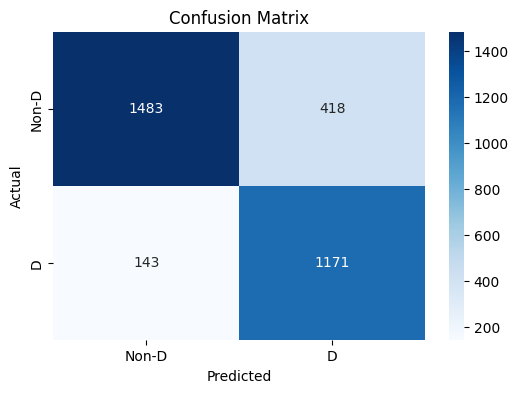

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
!pip install --upgrade gensim
import gensim.downloader

# Load datasets
d_tweets = pd.read_csv('d_tweets.csv')
non_d_tweets = pd.read_csv('non_d_tweets.csv')
clean_d_tweets = pd.read_csv('clean_d_tweets.csv')
clean_non_d_tweets = pd.read_csv('clean_non_d_tweets.csv')

# Combine datasets and label
d_tweets['label'] = 1
clean_d_tweets['label'] = 1
non_d_tweets['label'] = 0
clean_non_d_tweets['label'] = 0
data = pd.concat([d_tweets, clean_d_tweets, non_d_tweets, clean_non_d_tweets])

data['tweet'].fillna('', inplace=True)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

data['tweet'] = data['tweet'].apply(preprocess_text)

gt_vec = gensim.downloader.load('glove-twitter-50')

vocab_size = 5000
embedding_dim = 50
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(data['tweet'])
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in gt_vec.key_to_index:
        embedding_matrix[i] = gt_vec.word_vec(word)

sequences = tokenizer.texts_to_sequences(data['tweet'])
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(padded, data['label'], test_size=0.2, random_state=42)

# Build RNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-D', 'D'], yticklabels=['Non-D', 'D'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# New Section